In [1]:
#https://www.tensorflow.org/hub/tutorials/tf2_image_retraining
import itertools
import os
import shutil

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import os
import json
import kerastuner as kt
import PIL

In [2]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
GOOD = 0
BAD = 1

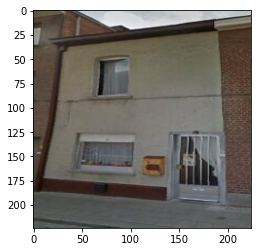

In [3]:
#training model with small dataset
with open('/home/jupyter/large-dataset/_annotations.json') as json_file: 
    annot = json.load(json_file) 
data=[]
labels=[]
imagePaths = []
data_dir = "/home/jupyter/data"
for label in os.listdir(data_dir):
    listdir = os.listdir(os.path.sep.join([data_dir,label]))
    if label == 'Good':
            bin_label = GOOD
    elif label == 'Bad':
        bin_label = BAD
    i=0
    while i <= (len(listdir)/2):
        filename = listdir[i]
        imagePath = os.path.sep.join([data_dir, label, filename])
        image = cv2.imread(imagePath)
        for item in annot['annotations']:
            if item == filename: 
                x = annot['annotations'][item][0]['x']
                y = annot['annotations'][item][0]['y']
                x2 = annot['annotations'][item][0]['x2']
                y2 = annot['annotations'][item][0]['y2']
        image = load_img(imagePath)
        width, height = image.size 
        image = image.crop((x*width, y*height, x2*width, y2*height))
        image = image.resize(IMAGE_SIZE)
        plt.imshow(image)
        image = img_to_array(image) / 255.0
        data.append(image)
        labels.append(bin_label)
        imagePaths.append(imagePath)
        i+=1
data = np.array(data)
labels = np.array(labels)
imagePaths = np.array(imagePaths)


In [4]:
print(labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [5]:
#splitting small dataset
#https://datascience.stackexchange.com/questions/15135/train-test-validation-set-splitting-in-sklearn
train_ratio = 0.70
validation_ratio = 0.15
test_ratio = 0.15

# train is now 70% of the entire data set
# the _junk suffix means that we drop that variable completely
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=1 - train_ratio)

# test is now 15% of the initial data set
# validation is now 15% of the initial data set
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

In [6]:
#tf.debugging.set_log_device_placement(True)
#with tf.device('/CPU:0'):
def model_builder(hp):
    vgg = VGG16(weights='imagenet', include_top = False, input_shape=(224, 224, 3))
    hp_dropout_rate1 = hp.Choice('rate1', values=[0.2, 0.5, 0.7])
    head = tf.keras.layers.Dropout(rate=hp_dropout_rate1)(vgg.output)
    x = GlobalAveragePooling2D()(head)
    x = BatchNormalization()(x)
    hp_dropout_rate2 = hp.Choice('rate2', values=[0.0, 0.2, 0.5])
    x = Dropout(hp_dropout_rate2)(x)
    x = Dense(1024,activation='relu')(x) 
    x = Dense(512,activation='relu')(x) 
    x = BatchNormalization()(x)
    hp_dropout_rate3 = hp.Choice('rate3', values=[0.0, 0.2, 0.5])
    x = Dropout(hp_dropout_rate3)(x)
    head = tf.keras.layers.Dense(1, activation = 'sigmoid',
                              kernel_regularizer=tf.keras.regularizers.l2(0.0001), name="class_label")(x)
    model = Model(
        inputs=vgg.input,
        outputs=(head))
    for layer in model.layers[:hp.Choice('num_frozen_layers', values=[0, 4, 7, 11, 15, 19])]:
        layer.trainable = False
    model.build((None,)+IMAGE_SIZE+(3,))
    model.summary()
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(
      optimizer = tf.keras.optimizers.Adam(lr=hp_learning_rate), 
      loss=tf.keras.losses.BinaryCrossentropy(from_logits=True, label_smoothing=0.1),
      metrics=['accuracy'])
    return model

In [7]:
#tf.debugging.set_log_device_placement(True)
#with tf.device('/CPU:0'):
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=20,
                     factor=3,
                     directory='/home/jupyter/Cropping-tuner/',
                     project_name='VGG16SmallTuner')
tuner.search_space_summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [8]:
#tuning
steps_per_epoch = len(x_train) // BATCH_SIZE
validation_steps = len(x_val) // BATCH_SIZE
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='auto', verbose=1)
#tf.debugging.set_log_device_placement(True)
#with tf.device('/CPU:0'):
tuner.search(x_train, y_train, epochs=50, steps_per_epoch=steps_per_epoch, 
         validation_data=(x_val, y_val), validation_steps=validation_steps, callbacks=[callback])
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 30 Complete [00h 00m 07s]
val_accuracy: 0.8399999737739563

Best val_accuracy So Far: 0.9200000166893005
Total elapsed time: 00h 07m 53s
INFO:tensorflow:Oracle triggered exit


In [9]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print('lr: '+str(best_hps['learning_rate']))
print('layers: '+str(best_hps['num_frozen_layers']))
print('rate1: '+str(best_hps['rate1']))
print('rate2: '+str(best_hps['rate2']))
print('rate3: '+str(best_hps['rate3']))

lr: 0.0001
layers: 15
rate1: 0.2
rate2: 0.5
rate3: 0.0


In [10]:
#training
model = tuner.hypermodel.build(best_hps)
hist = model.fit(
    x_train, y_train,
    epochs=50, steps_per_epoch=steps_per_epoch,
    validation_data=(x_val, y_val),
    validation_steps=validation_steps, callbacks=[callback]).history

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

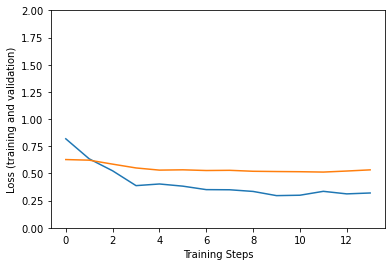

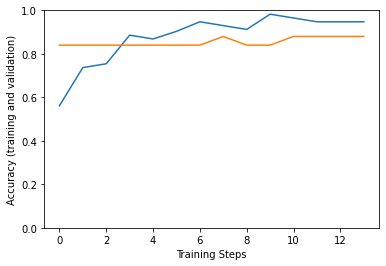

In [11]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

In [12]:
#https://www.tensorflow.org/tutorials/keras/save_and_load?fbclid=IwAR3JVn-_CLqgNuKO3G92cMYCNqVL81oxVs3bP6QhfgFLPiE4VbEMK2QQffc
loss, acc = model.evaluate(x_test, y_test, verbose=2)

1/1 - 1s - loss: 0.5973 - accuracy: 0.7600


In [20]:
print(len(y_test))
print("%bad test set: " + str(y_test.sum()/len(y_test)))
print(len(y_val))
print("%bad val set: " + str(y_val.sum()/len(y_val)))
print(len(y_train))
print("%bad train set: " + str(y_train.sum()/len(y_train)))

25
%bad test set: 0.32
25
%bad val set: 0.16
114
%bad train set: 0.2807017543859649


In [21]:
saved_model_path = "/home/jupyter/Cropping-tuner/VGG-SmallDataModel"
tf.saved_model.save(model, saved_model_path)

INFO:tensorflow:Assets written to: /home/jupyter/Cropping-tuner/VGG-SmallDataModel/assets


In [22]:
model.save('VGG-SmallDatasetModel.h5')